# 1. Setup and Load Data

## 1.1 Install Dependencies and Setup

In [78]:
# get tensorflow to work on your enviroment (install once)
# !pip install tensorflow tensorflow-metal

# opencv is used for image visualization (install once)
# !pip install opencv-python 

# Check if all neccesary dependancies are installed
# !pip list

In [79]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [80]:
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [81]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.2 Remove Doggy Images


In [82]:
# some image related librbary called openCV
import cv2

# to check image extension
import imghdr

In [83]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [84]:
# in this case, the dataset used is maintained in an excellent manner with no weird files, extensions or issues so no files were removed

for image_class in os.listdir(data_dir):
    if image_class == '.DS_Store' : continue
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            # opens image as a numpy array to see if its readable by openCV
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

## 1.3 Load Data


In [85]:
# using keras api were building a data structure that will take in a directory and hold all the images as numpy arrays. Each image will also be given a label depending on whih subfolder it is from (in our case cat and dog)

# properties of a batch are det to default in tf.keras.utils.image_dataset_from_directory but can be modified such as image conversion size and batch size

# the structure below itslef is just a generator and not in memory therefore the next keyword is used to loop through to get a specific bacth
data = tf.keras.utils.image_dataset_from_directory(data_dir)
data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

Found 697 files belonging to 2 classes.


In [86]:
# the structure below has 2 items
# 0 represents all the images in that specific bacth as numpy arrays
# 1 represents the assinged label which we'll have to figure out 

batch[0].shape

(32, 256, 256, 3)

In [87]:
batch[1].shape

(32,)

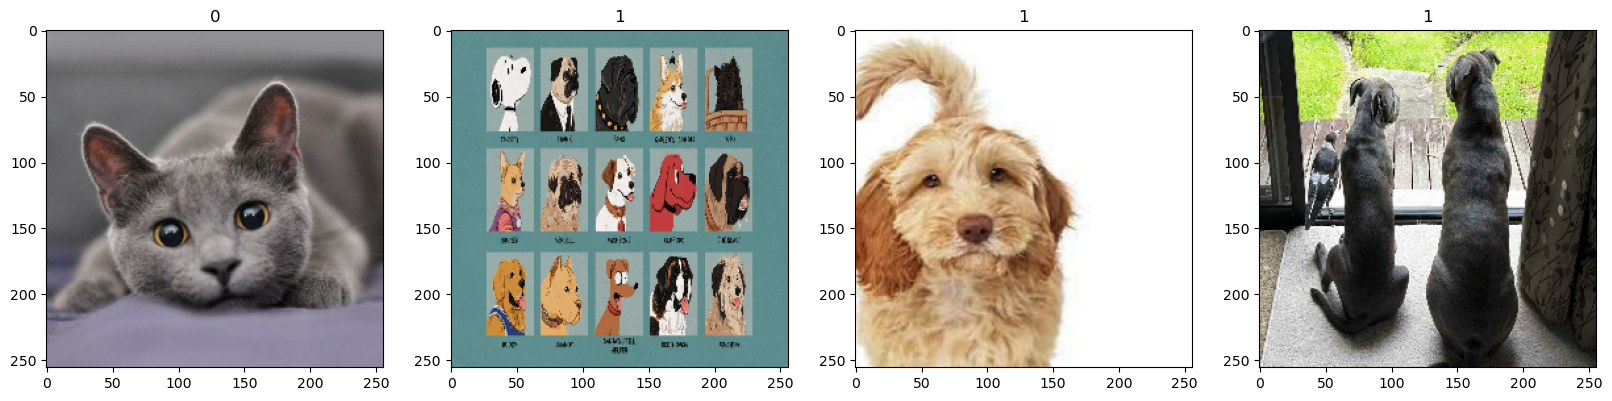

In [88]:
# let's plot an image and compare it see which label belongs to which subfolder
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [89]:
# As for the labels, 0 represents cats and 1 represents dogs

# 2. Preprocess Data
## 2.1 Scale and Shuffle Data

In [90]:
data.cardinality().numpy() # this returns the number of batches in the dataset

22

In [91]:
# shuffling with the total count of batches gives the best shuffle however the cardinality does not return a number instead something unknown to my kind
data = data.shuffle(data.cardinality())

In [92]:
# originally tf.keras.preprocessing.image_dataset_from_directory genrates a tf.data.Dataset which has many functions for data pipelining
# a property of tf.data.Dataset is the map function

# the lambda is a python feature that states the multiple arguments (thats not the actual purpose but thats what it does here)
# x represents the pixel values as whole numbers an y is the label
data = data.map(lambda x, y : (x/255, y))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

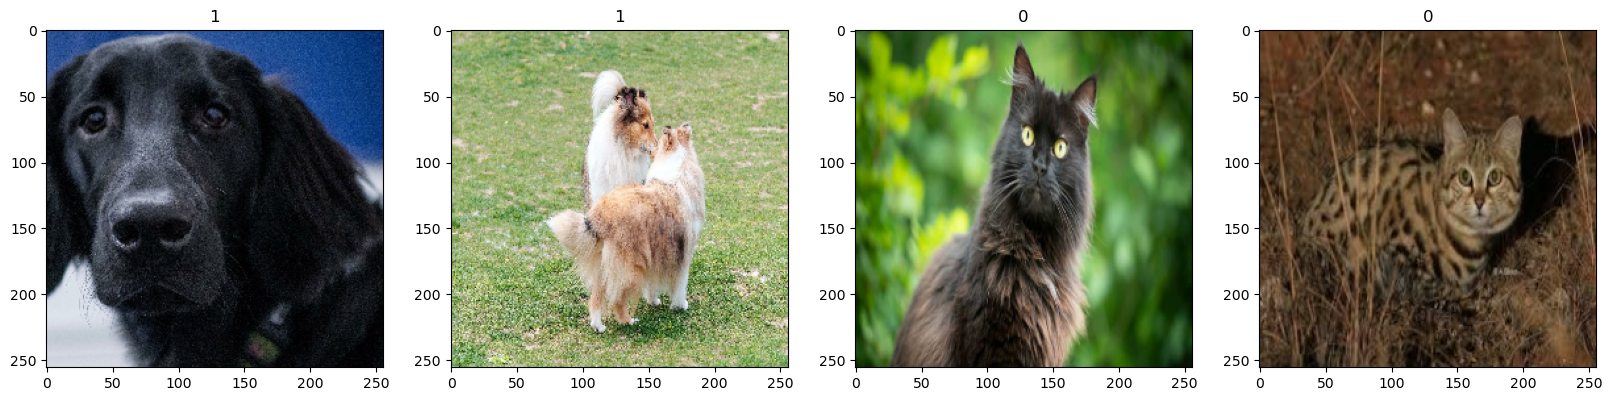

In [93]:
# plot with the scalled value to see if scaling was applied correctly

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) # as type int was removed as all number were scalled to between 0 and 1 
    ax[idx].title.set_text(batch[1][idx])

## 2.2 Split Data

In [94]:
len(data)

22

In [95]:
train_size = 15
val_size = 4
test_size = 3

In [96]:
# the skip function skips the batches until that particular index
# the take batch takes all the batchs until that index

# using skip and take, we can split the shiffled data into train, validate and testing sets

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(val_size + train_size).take(test_size)

# 3. Deep Learning
## 3.1 Build Deep Learning Model

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [98]:
# maxpool2d is by default set to 2 x 2 so the width and height of input will be divided by two after every maxpool layer
# flatten makes the multi dimentional array into a 1D array of all the values
# Dense uses weighted sums to calculate an overall value

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [99]:
# the first param is the optimization function for gradient descent 
# the second param is the loss function used to to calculate the difference between the actual value and the predicted value
# the third param is the accuracy which predicts the fraction o fthe sample the model predicted correctly

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [100]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

## 3.2 Train

In [101]:
logdir = 'logs'
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [102]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorflow_callback])

Epoch 1/20


2025-01-01 12:15:19.417599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/15 [===========================>..] - ETA: 0s - loss: 0.7157 - accuracy: 0.5057

2025-01-01 12:15:21.616917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 147ms/step - loss: 0.7139 - accuracy: 0.5159 - val_loss: 0.6867 - val_accuracy: 0.5469
Epoch 2/20
15/15 [==============================] - 3s 130ms/step - loss: 0.6863 - accuracy: 0.5375 - val_loss: 0.6829 - val_accuracy: 0.4711
Epoch 3/20
15/15 [==============================] - 3s 126ms/step - loss: 0.6693 - accuracy: 0.5708 - val_loss: 0.6412 - val_accuracy: 0.6406
Epoch 4/20
15/15 [==============================] - 3s 126ms/step - loss: 0.6078 - accuracy: 0.6596 - val_loss: 0.5215 - val_accuracy: 0.6953
Epoch 5/20
15/15 [==============================] - 3s 130ms/step - loss: 0.5001 - accuracy: 0.7590 - val_loss: 0.4456 - val_accuracy: 0.7578
Epoch 6/20
15/15 [==============================] - 3s 126ms/step - loss: 0.4769 - accuracy: 0.7979 - val_loss: 0.3354 - val_accuracy: 0.8672
Epoch 7/20
15/15 [==============================] - 3s 127ms/step - loss: 0.3493 - accuracy: 0.8478 - val_loss: 0.3115 - val_accuracy: 0.8906
Epoch 8/20
15/15 

In [103]:
hist.history

{'loss': [0.7138577103614807,
  0.6862983703613281,
  0.6692845821380615,
  0.6077659726142883,
  0.5000512003898621,
  0.47691214084625244,
  0.3492725193500519,
  0.2647806406021118,
  0.2166755348443985,
  0.14406120777130127,
  0.12675520777702332,
  0.14352862536907196,
  0.11168315261602402,
  0.06155017763376236,
  0.05410075560212135,
  0.027151118963956833,
  0.024661079049110413,
  0.008698169142007828,
  0.008900007233023643,
  0.016598084941506386],
 'accuracy': [0.5158562660217285,
  0.5375000238418579,
  0.5708245038986206,
  0.6596194505691528,
  0.7589852213859558,
  0.7979166507720947,
  0.8477801084518433,
  0.9125000238418579,
  0.9196617603302002,
  0.9556025266647339,
  0.9386892318725586,
  0.94291752576828,
  0.972515881061554,
  0.9791666865348816,
  0.9854166507720947,
  1.0,
  0.9894291758537292,
  1.0,
  1.0,
  0.9978858232498169],
 'val_loss': [0.68674635887146,
  0.6829270124435425,
  0.6412107944488525,
  0.5215061902999878,
  0.4456219971179962,
  0.33539

## 3.3 Plot Performance

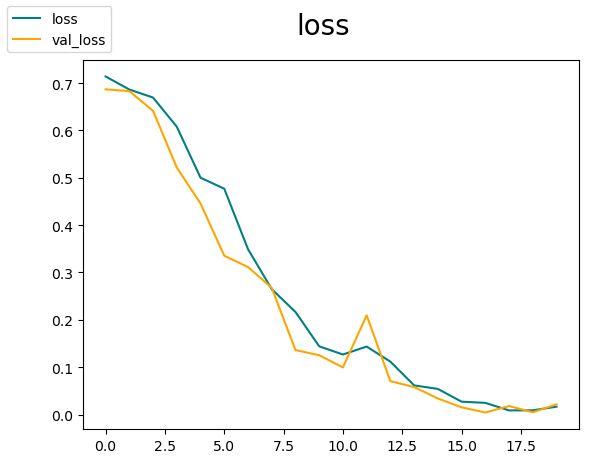

In [104]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
fig.legend(loc='upper left')
plt.show()

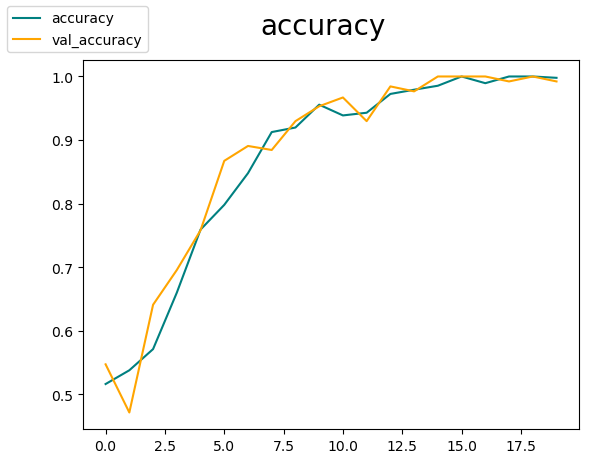

In [105]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
fig.legend(loc='upper left')
plt.show()

# 4. Evaluate Performance
## 4.1 Evaluate

In [106]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [107]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [108]:
for batch in test.as_numpy_iterator():
    x, y = batch
    ypredict = model.predict(x)
    pre.update_state(y, ypredict)
    re.update_state(y, ypredict)
    acc.update_state(y, ypredict)

1/1 [==============================] - 0s 21ms/step


2025-01-01 12:16:21.736815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [109]:
print(f'Precision : {pre.result()} \nRecall : {re.result()} \nBinary Accuracy : {acc.result()}')

Precision : 0.9622641801834106 
Recall : 1.0 
Binary Accuracy : 0.9791666865348816


# 4.2 Test


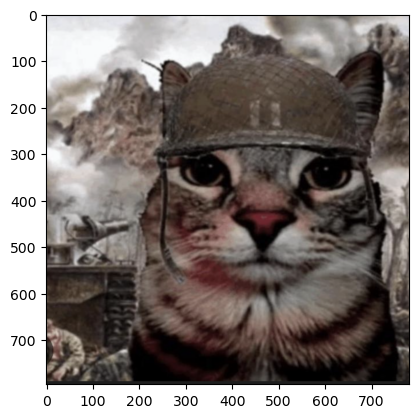

In [110]:
# testing with a random image 

sample_image_cat_path = os.path.join('/Users/abbazs/Projects/ML-Data-Science/image-classification-2', 'sample_image_cat.png')
image_bgr = cv2.imread(sample_image_cat_path)
image_rgb = plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))

In [111]:

#resize image to fit models standards
test_img = tf.image.resize(image_bgr, (256,256)) /255

# the below code adds an extra dimension to replicate a batch scenario since the model was trained in batches
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

1/1 [==============================] - 0s 43ms/step


2025-01-01 12:16:22.122433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [112]:
print(prediction)

[[0.00482214]]


# 5. Save Model
## 5.1 Save the model

In [113]:
model.save(os.path.join('models', 'catvsdog.h5'))

## 5.2 Load Model

In [114]:
from tensorflow.keras.models import load_model
new_model = load_model(os.path.join('models', 'catvsdog.h5'))
print(new_model.predict(np.expand_dims(tf.image.resize(image_bgr, (256,256))/255, 0)))

1/1 [==============================] - 0s 44ms/step
[[0.00482214]]


2025-01-01 12:16:22.381182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
